# import data and preprocess

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = 'your_name'
os.environ['KAGGLE_KEY'] = 'your_key'
!kaggle datasets list -s pneumonia
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [2]:
import zipfile

local_zip = '/content/chest-xray-pneumonia.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

local_zip = '/content/chest_xray.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

print(os.listdir('/content/'))
print(os.listdir('/content/chest_xray'))

['.config', 'chest_xray.zip', '__MACOSX', 'chest-xray-pneumonia.zip', 'chest_xray', 'sample_data']
['.DS_Store', 'train', 'val', 'test']


In [3]:
train_dir = os.path.join('/content/chest_xray/train')
test_dir = os.path.join('/content/chest_xray/test')
val_dir = os.path.join('/content/chest_xray/val')

print('total train:', os.listdir(train_dir))
print('total test:', os.listdir(test_dir))
print('total val:', os.listdir(val_dir))

total train: ['.DS_Store', 'NORMAL', 'PNEUMONIA']
total test: ['.DS_Store', 'NORMAL', 'PNEUMONIA']
total val: ['.DS_Store', 'NORMAL', 'PNEUMONIA']


# train model

In [0]:
!pip install tensorflow-gpu==2.0.0.rc1

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout

%matplotlib inline

In [0]:
base_model = tf.keras.applications.InceptionV3(input_shape = (150, 150, 3), include_top = False, weights="imagenet")

In [8]:
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
global_average_layer = Dense(512, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(256, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(128, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
prediction_layer = tf.keras.layers.Dense(units=2, activation='sigmoid')(global_average_layer)
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)

train_gen = data_gen_train.flow_from_directory(train_dir, target_size=(150,150), batch_size=128, class_mode="categorical")
valid_gen = data_gen_valid.flow_from_directory(val_dir, target_size=(150,150), batch_size=128, class_mode="categorical")
test_gen = data_gen_valid.flow_from_directory(test_dir, target_size=(150,150), batch_size=128, class_mode="categorical")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
model.fit_generator(train_gen, epochs = 5, validation_data = valid_gen)

Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
41/41 [==============================] - 1382s 34s/step - loss: 0.5554 - accuracy: 0.7289 - val_loss: 0.6823 - val_accuracy: 0.5000
Epoch 2/5
41/41 [==============================] - 1365s 33s/step - loss: 0.3629 - accuracy: 0.8414 - val_loss: 1.2105 - val_accuracy: 0.6875
Epoch 3/5
41/41 [==============================] - 1368s 33s/step - loss: 0.2848 - accuracy: 0.8861 - val_loss: 1.4686 - val_accuracy: 0.6250
Epoch 4/5
41/41 [==============================] - 1371s 33s/step - loss: 0.2466 - accuracy: 0.9030 - val_loss: 1.4309 - val_accuracy: 0.5625
Epoch 5/5
41/41 [==============================] - 1369s 33s/step - loss: 0.2181 - accuracy: 0.9147 - val_loss: 1.4542 - val_accuracy: 0.6250


# visualize accuracy of model

In [18]:
loss, accuracy = model.evaluate_generator(valid_gen)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.625


In [0]:
def compare_results(root_path, generator):

  predictions = model.predict_generator(generator) # Return numpy array of predictions
  class_predicted= [np.argmax(prediction) for prediction in predictions]
  fig = plt.figure(figsize=(24, 18))
  fig.subplots_adjust(hspace=1.5)
  
  normal_path = root_path + '/NORMAL/'
  pneumonia_path = root_path + '/PNEUMONIA/'
  
  normal_dir = os.listdir(normal_path)
  pneumonia_dir = os.listdir(pneumonia_path)
  
  # Generators
  normal_gen =  (x for x in normal_dir if x.endswith('.jpeg'))
  pneumonia_gen =  (y for y in pneumonia_dir if y.endswith('.jpeg'))
  
  for i, normal_file in enumerate(normal_gen):
    img = plt.imread(normal_path + normal_file)
    plt.subplot(4, 4, 1 + i)
    plt.title(f"Prediction: NORMAL\nTrue value: NORMAL" if class_predicted[i] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: NORMAL")
    plt.imshow(img)
    
  for j, pneumonia_file in enumerate(pneumonia_gen):
    img = plt.imread(pneumonia_path + pneumonia_file)
    plt.subplot(4, 4, 9 + j)
    plt.title(f"Prediction: NORMAL\nTrue value: PNEUMONIA" if class_predicted[8+j] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: PNEUMONIA")
    plt.imshow(img)

ValueError: ignored

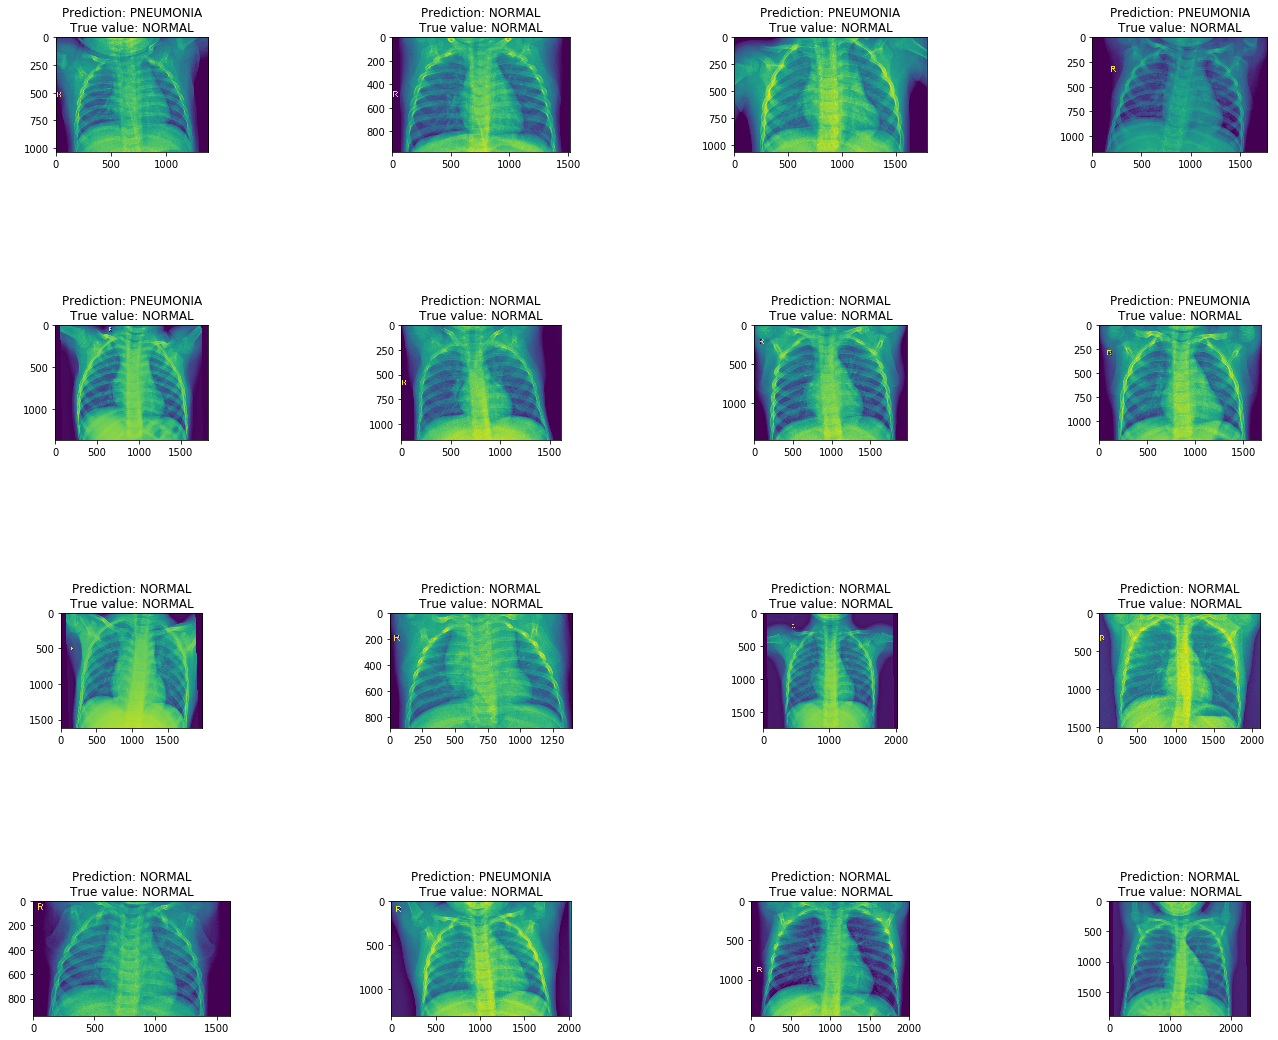

In [22]:
compare_results(test_dir, test_gen)